In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
np.random.seed(42)
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib.colors import get_named_colors_mapping
get_named_colors_mapping()["r"] = "#ff6961"
get_named_colors_mapping()["b"] = "#1AA7EC"
plt.rcParams.update({'font.size': 12})
from meteostat import Point, Daily
import time
from src.data import extract

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import statsmodels.api as sm
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import statsmodels.tsa.stattools as sts
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             mean_absolute_percentage_error)


## Introduction

People hate delayed public transportation. Every year thousands of minutes are spend waiting on delayed public transportation including delayed flights. 

- The goal is to predict the number the delayed departure minutes. 

Given the target to predict the number of delayed departure minues, three different temporal models are built, namely an AR(1)-model, an AR(2)-model and a AR(2)-model that includes weather featuers. These models are based of Linear Dynamical systems (LDS). In Linear Dynamical Systems the transition probabilites $(h_t)$ and observation probabilities $(y_t)$ are given by: 

\begin{align}
\mathbf h_t &\sim \mathcal{N}(\mathbf h_t | \boldsymbol\beta \mathbf h_{t-1} + \mathbf{w} \mathbf{x_t}, \boldsymbol \tau )\\
y_t &\sim \mathcal{N}(y_t | \mathbf c^{T} \mathbf h_{t}, \mathbf \sigma^{2} )\\
\end{align}

In this project, the observations $(y_t)$ are believed only to be dependent on the hidden state hence $...

## Generative process

1. Draw transition coefficients $\boldsymbol{\beta}$ for the hidden states, *$\boldsymbol{\beta}$*~ $\mathcal{N}$(**0**, *$\boldsymbol{\lambda}_1$*)
2. Draw global variance for the observations,  $ \sigma^2$ ~ HalfCauchy($\sigma^2 |   \lambda_2$)
3. Draw global variance for the transitions,  $ \tau $ ~ HalfCauchy($ \tau |   \lambda_2$)
4. Draw first hidden state,  $ h_1$ ~ $\mathcal{N}$($ h_1 | \mu_0 + \mathbf{w} \mathbf{x_1},  \tau_0$)
5. Draw second hidden state,  $h_2$ ~ $\mathcal{N}$($ h_2 | \beta_1 h_{1} + \mathbf{w} \mathbf{x_2}, \tau$)
6. For each time t $\in (1,2)$:
    1. Draw observation noise,  $\epsilon_t$ ~  $\mathcal{N}$($\epsilon_t | 0,  \sigma^2$)
    2. Draw observation,  $y_t$ ~ $\mathcal{N}$($y_t | h_t,  \epsilon_t$)
7. for each time t $\in (3,...,T)$:
    1. Draw transition noise,  $r_t$ ~  $\mathcal{N}$($r_t | 0,  \tau$)
    2. Draw transition probability,  $h_t$ ~ $\mathcal{N}$($ h_t | \beta_1 \cdot h_{t-1}+\beta_2 \cdot h_{t-2} + \mathbf{w} \mathbf{x_t},  r_t$)
    3. Draw observation noise,  $\epsilon_t$ ~  $\mathcal{N}$($\epsilon_t | 0,  \sigma^2$)
    4. Draw observation, $y_t$ ~ $\mathcal{N}$($y_t |  h_t,  \epsilon_t$)

## Data Preprocessing

Data preprocessing to be used for modeling. The data is grouped on a daily basis and enriched with weather data. The weather data is retrieved from Meteostat's API. 

In [2]:
def prep_data(df):
    """
    Preprocess data to be used for modeling.
    """
    # select columns
    col_list =['FlightDate','Origin','DepDelayMinutes']
    df = df[col_list]
    
    # convert to datetime
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    start_date = df['FlightDate'].min()
    end_date = df['FlightDate'].max()
    
    # select departure airport
    df = df[df['Origin'] == 'DEN']

    # set cancelled flights to zero delay min
    df['DepDelayMinutes'] =  df['DepDelayMinutes'].fillna(0)

    # group data
    df['FlightCount'] = 1
    df = df.groupby('FlightDate').agg({'DepDelayMinutes': 'mean', 'FlightCount': 'sum'})

    # add row for missing days in dataset
    idx = pd.date_range(start_date, end_date, freq='D')
    df = df.reindex(idx, fill_value=0)

    # add weather data
    weather_data = Daily(Point(39.855229533349956, -104.67398600087793), start_date, end_date).fetch()
    weather_data = weather_data.drop(['snow', 'wpgt', 'tsun', 'tmin', 'tmax'], axis=1)
    df = df.merge(weather_data, left_index=True, right_index=True)
    
    # replace missing weather data with mean values
    df[['tavg', 'prcp', 'wdir', 'wspd', 'pres']].fillna(
        value=df[['tavg', 'prcp', 'wdir', 'wspd', 'pres']].mean(), inplace=True)
    
    return df

In [3]:
main_df = extract.combine_parquet(data_path = 'data/')
df = prep_data(main_df)
df.to_csv('data/cleaned_data.csv')
#df = pd.read_csv('data/cleaned_data.csv', index_col=0)

In [4]:
df.head(3)

,DepDelayMinutes,FlightCount,tavg,prcp,wdir,wspd,pres
2018-01-01,19.273669,676,-11.3,0.0,NaN,8.6,1029.9
2018-01-02,17.784810,711,-6.0,0.0,216.0,13.0,1029.6
2018-01-03,12.787234,705,-0.1,0.0,189.0,17.3,1024.2


## Evaluation Metrics

To compare the different models an evaluation function is defined using multiple evaluation metrics. 

In [5]:
def evaluate(y_pred, y_true):
    """
    Use evalutation metrics to evaluate predictions.
    mse, mae, r2
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred, squared=True)
    r2 = r2_score(y_true, y_pred)
    return {'mse': mse,'r2': r2, 'mae': mae}

## Verification AR(1)-Model

In this section, the an AR(1)-model is built and verified. It is verfired by making sure that it is able to detect the paramter values used in the ancestral sampling process. The AR(1) model is the simplest temporal model explored in this project. This model along with other more complex models will be used for predictions in the prediction section. 

AR-models are linear dynamical systems...

In [51]:
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(1) - Model
    """
    # Priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample('beta', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(10.))
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(10.))
    z_1 = numpyro.sample('z_1', numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 as AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

Below ancestral sampling is performed and the dataset is split into test and training data.

In [56]:
# Ancestral sampling

# Assume sigma and tau to be fixed
tau = 1.
sigma = 1.

# Sample beta coefficient 
beta = np.random.normal(0.,1.)

# Time series length
T = 10000

# Vector to store sampled latent states
z = np.zeros(T)
 # Vector to store sampled observations
y = np.zeros(T)

# Sample latent states Z
z[0] = np.random.normal(0,1.) # First latent state is sampled separately 
for t in range(1,T):
    z[t] = np.random.normal(beta * z[t-1], tau) 
    
# Sample observations y
for t in range(T):
    y[t] = np.random.normal(z[t], sigma)

In [57]:
# Split in train and test data
y_train, y_test = train_test_split(y, test_size=0.01, shuffle=False)

N_train = len(y_train)
N_test = len(y_test)
print(f'N_train: {N_train}')
print(f'N_test:, {N_test}')

N_train: 9900
N_test:, 100


The MCMC algorithm is used to perform inference. 

 All inference is done using MCMC

In [58]:
# Scan function to propogate dynamics
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    # Define priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample("beta", numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample("tau", numpyro.distributions.HalfCauchy(10.))
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfCauchy(10.))
    z_1 = numpyro.sample("z_1", numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample("noises", numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 because AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample("y_obs", numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample("y_pred", numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [59]:
# Run inference using MCMC
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=500, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|███████████████████████████| 1500/1500 [00:46<00:00, 31.93it/s, 31 steps of size 1.07e-01. acc. prob=0.88]


Total time: 0.836m


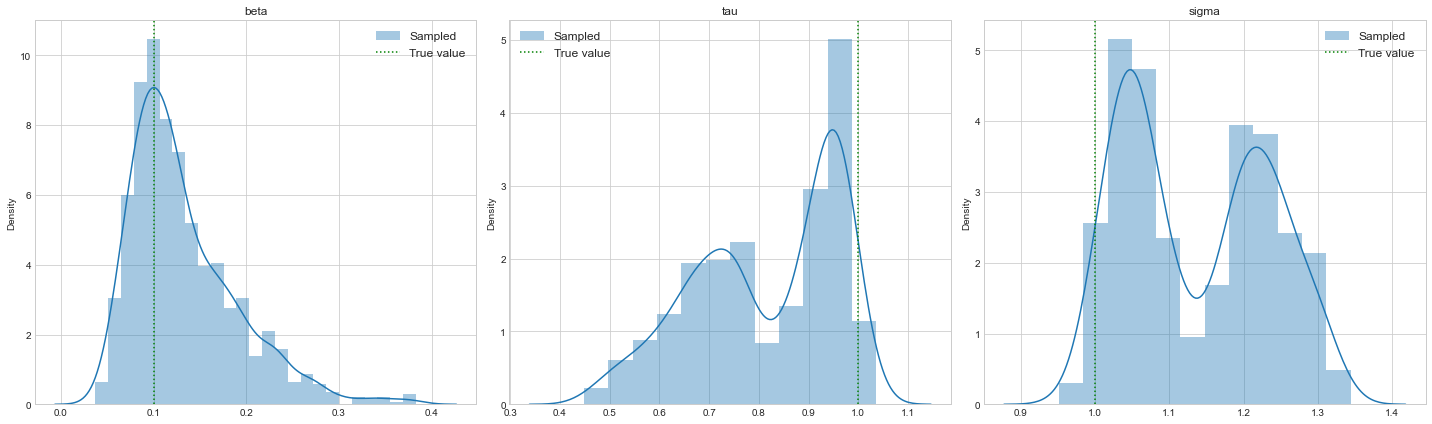

In [61]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

nodes = ['beta', 'tau', 'sigma']
fig, axes = plt.subplots(1,3, figsize=(20,6))
true_values = [beta, tau, sigma]

for i, node in enumerate(nodes):
    sns.distplot(hmc_samples[node], label='Sampled', ax=axes[i])\
        .axvline(true_values[i], color='g', ls=':', label='True value')
    axes[i].legend(fontsize=12)
    axes[i].set_title(node)
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(1)_verification.png', bbox_inches='tight')

In [12]:
print('Estimated latent variables')
print('beta:', hmc_samples['beta'].mean())
print('tau:', hmc_samples['tau'].mean())
print('sigma:', hmc_samples['sigma'].mean())

Estimated latent variables
beta: 0.46877933
tau: 1.0510662
sigma: 0.96832746


In [13]:
print('True values of latent variables')
print('beta:', beta)
print('tau:', tau)
print('sigma:', sigma)

True values of latent variables
beta: 0.4967141530112327
tau: 1.0
sigma: 1.0


In [14]:
def plot_preds(y_pred, y_pred_std, y_true):
    plot_df = pd.DataFrame()
    plot_df['true'] = y_true
    plot_df['pred'] = np.array(y_pred.mean(axis=0))

    plot_df['pred_025'] = plot_df['pred'].values - y_pred_std.values
    plot_df['pred_975'] = plot_df['pred'].values + y_pred_std.values

    fig, ax = plt.subplots( figsize = (20, 8))
    plot_df['true'].plot(style='g-', marker='o', label='True values')
    plot_df['pred'].plot(style='b-', marker='o', label='Predicted values')
    plot_df['pred_025'].plot(style='b--')
    plot_df['pred_975'].plot(style='b--')
    plt.fill_between(plot_df['pred_025'].index, plot_df['pred_025'], plot_df['pred_975'], alpha=0.3, 
                     label='95% confidence interval', color='b')
    plt.title('Predicted test values')

    plt.legend(['True values','Predicted', '95% confidence interval'], loc='upper right');

## Stationarity and Differencing

Temporal models such as the ARIMA model can only model stationary time series. A stationary time series has constant mean, variance and autocorrelation over time. Therefore, trends and seasonality should be removed from the time series before modeling. 

The Augmented Dickey-Fuller (ADF) test can be used to test for stationarity. The null-hypothesis is non-stationarity and the alternative is hypothesis is stationarity. [[1]](https://www.linkedin.com/advice/0/what-advantages-disadvantages-stationarizing-your-data)



In [15]:
f'p-value for ADF-test {sts.adfuller(df.DepDelayMinutes)[1]}'

'p-value for ADF-test 2.871052354984356e-05'

With a significance level on 0.05, the null-hypothesis is rejected and the ADF test indicates that the timeseries is stationary.

Differencing can make the data more stationary by removing seasonality or trends. The graph below shows the orginal data and the data differenced by lag=1. 

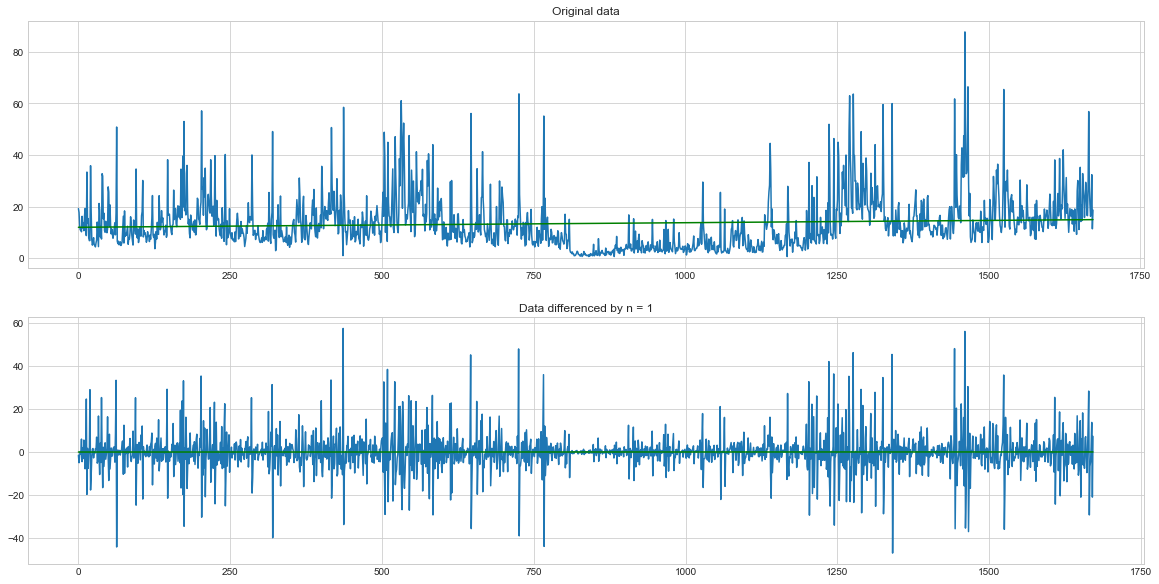

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

y = df['DepDelayMinutes']
x = range(0, y.shape[0])

# Original data, no transformations
p = np.poly1d( np.polyfit(x, y.dropna(), 1))
ax[0].plot(x,y)
ax[0].plot(x, p(x), 'g-')
ax[0].set_title('Original data', fontsize=12);

# Differenced with 1
x1 = range(0, y.diff(1).dropna().shape[0])
p_diff1 = np.poly1d(np.polyfit(x1, y.diff(1).dropna(), 1))
ax[1].plot(x1,y.diff(1).dropna())
ax[1].plot(x1, p_diff1(x1), 'g-')
ax[1].set_title('Data differenced by n = 1', fontsize=12);
plt.savefig('figures/timeseries_differentiation.png', bbox_inches='tight')

By differencing by 1, it seems like a trend in how the depature dalay minutes variate over time is removed. To further investigate it, the autocorrelation (ACF) and partial autocorrelation (PACF) are inspected. 

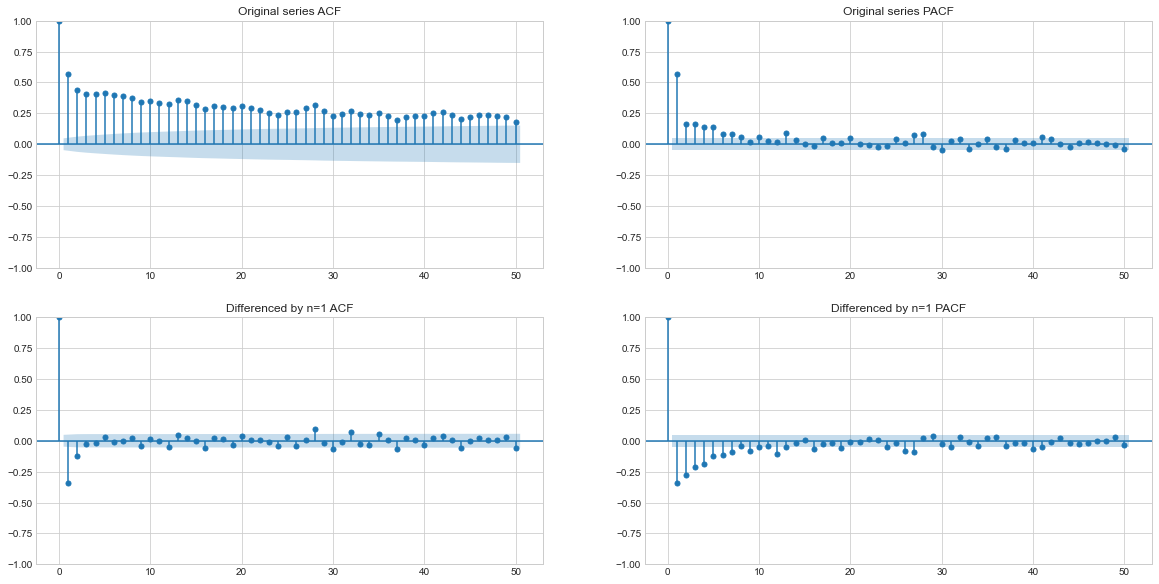

In [17]:
fig, axes = plt.subplots(2,2, figsize=(20,10))
axes = axes.flatten()
sm.graphics.tsa.plot_acf(y,title='Original series ACF',lags=50, ax=axes[0]);
sm.graphics.tsa.plot_pacf(y,title='Original series PACF',lags=50, ax=axes[1]);
sm.graphics.tsa.plot_acf(y.diff(1).dropna(),title='Differenced by n=1 ACF',lags=50, ax=axes[2]);
sm.graphics.tsa.plot_pacf(y.diff(1).dropna(),title='Differenced by n=1 PACF',lags=50, ax=axes[3]);
plt.savefig('figures/pacf_acf.png', bbox_inches='tight')

Looking at the ACF plot for the original data a slow decay in the ACF plot is seen indicating a trend or seasonality pattern. This slow dacay pattern is removed from the timeseries that is differenced by 1. Here only one significant lag is observed. As this indicates that differencing by 1 makes the timeseries more stationary, this data transformation is applied to the data.

The first two lags are significant in the PACF plot when the data is differenced once. This indicates that an AR(2) model is a potential fit to the data. 

In [18]:
# difference by 1
df['diff_DepDelayMinutes'] = df['DepDelayMinutes'].diff(1)

# Feature columns
X = df.drop(['DepDelayMinutes'],axis=1).iloc[1:]

# Target column differentiated
y = df['diff_DepDelayMinutes'].iloc[1:]

# Target column undifferentiated
v = df['DepDelayMinutes'].iloc[1:]

# Split in train and test data
X_train, X_test, y_train, y_test, v_train, v_test = train_test_split(X, y, v, test_size=0.10, shuffle=False)

In [19]:
print("N_train:", len(X_train))
print("N_test:", len(y_test))

N_train: 1504
N_test: 168


Once the prediction are made using a temporal model and differenced data, it needs to be backdifferenced in order to compare it to the original untransformed data. Below a helper function is defined as well as function that can calculate confidence intervals for the predictions.

In [20]:
def BackDifferencing(y_train_undiffed, y_pred, y_train, test_start, lags=1):
    
    """
    Function to backdifference predicted values.
    """

    len_df = len(y_pred.T) + len(y_train) + lags
    restored = []
    y = []
    y.extend(np.full(lags, np.nan))
    y.extend(y_train)
    y.extend(y_pred.T) 
    y_diff = y[:test_start] + [i.mean() for i in y[test_start:]]
    
    for i in range(test_start-lags):
        restored.append(y_train_undiffed[i] + y_diff[i+lags])
    y_back= [np.nan]*(lags) + restored + [np.nan]*(len_df-test_start)

    for i in range(test_start-lags, len_df-lags):
        y_back[i+lags] = y_back[i] + y_diff[i+lags]

    for i in range(test_start-lags, len_df-lags):
        restored.append(y_back[i] + y[i+lags])

    y_back = [np.nan]*(lags) + restored
    y_pred = y_back[:test_start] + [i.mean() for i in y_back[test_start:]]

    return pd.Series(y_pred).astype(float)

In [21]:
def CI95(y_pred):
    """
    Calculated 95% confidence intervals for predictions.
    """
    return pd.Series([1.96*i.std() for i in y_pred.T]).astype(float)

Above the sampled parameter values are compared to the true parameter value used for ancestral sampling. It appears that the model approximates the parameter distributions so the model is assumed to be working correctly. 

## AR(1) Model

With a model that is verified in the perivous section. It can now be tried on the real data. The model priors of $\beta$, $\tau$, $\sigma$, $z_1$ and $\epsilon$ are assigned by a trial and error. For indication of correct values, the timeseries plot of the differenced timeseries is used. Here it is seen that the values are centered around zero and mainly fluctuates between 0 and 10.

Below the model is applied to the actual data, modeling the departure delay minutes. 

In [22]:
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t
    z_prev = z_t
    return (beta, z_prev, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(1)-model
    """
    # Priors over beta, tau, noises, sigma, z_1
    beta  = numpyro.sample('beta', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(0.1))
    z_1 = numpyro.sample('z_1', numpyro.distributions.Normal(0.,1.))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0.,1.),
                            sample_shape=(T+T_forecast-1,))# -1 as AR(1)
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_1, tau)
    z_collection = jnp.array([z_1])
    carry_updated, z_collection2 = lax.scan(f=f, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((z_collection,z_collection2))
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    
    return z_collection

In [23]:
# Run inference using MCMC
t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|██████████████████████████| 3000/3000 [00:50<00:00, 58.84it/s, 255 steps of size 2.46e-02. acc. prob=0.20]


Total time: 0.933m


In [24]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar1_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar1_std =CI95(hmc_samples['y_pred'])

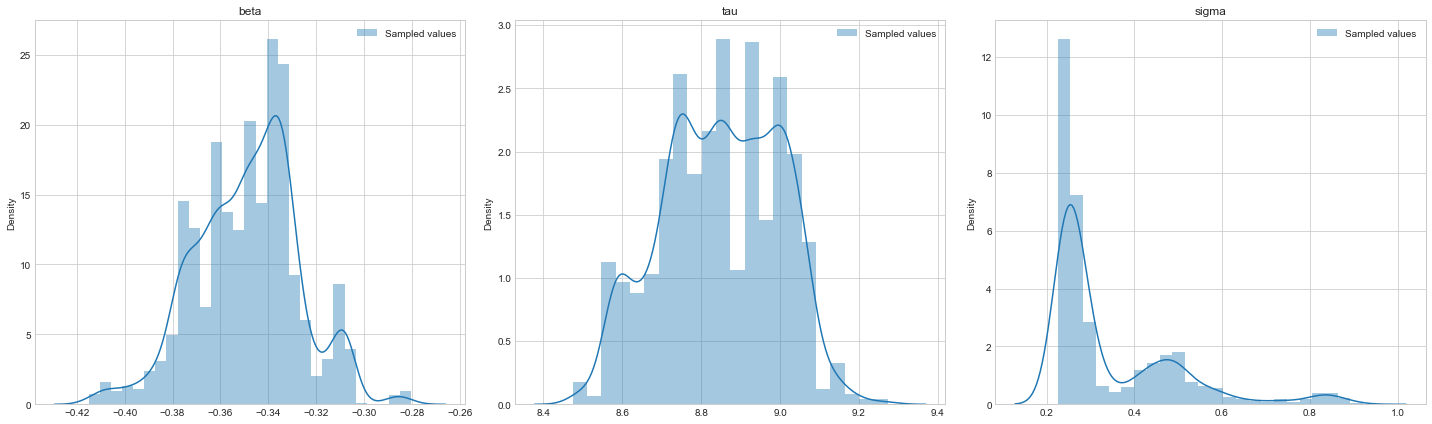

In [25]:
# Visualization of the posterior distributions
nodes = ['beta', 'tau', 'sigma']
fig, axes = plt.subplots(1,3, figsize=(20,6))
axes = axes.flatten()
for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(1).png', bbox_inches='tight')

It is seen that $\boldsymbol{\tau}$ values are quit significant compared to the $\boldsymbol{\beta}$ and $\boldsymbol{\sigma}$ values, as the sample values are higher. This indicates that global variance is high. A lower  $\boldsymbol{\beta}$  value indicates that the previous time step t-1 is less important predicting the target value. 

In [26]:
def plot_preds(y_pred, y_pred_std, y_true, model_name):
    plot_df = pd.DataFrame()
    plot_df['true'] = y_true
    plot_df['pred'] = np.array(y_pred.mean(axis=0))

    plot_df['pred_025'] = plot_df['pred'].values - y_pred_std.values
    plot_df['pred_975'] = plot_df['pred'].values + y_pred_std.values

    fig, ax = plt.subplots( figsize = (20, 8))
    plot_df['true'].plot(style='g-', marker='o', label='True values')
    plot_df['pred'].plot(style='b-', marker='o', label='Predicted values')
    plot_df['pred_025'].plot(style='b--')
    plot_df['pred_975'].plot(style='b--')
    plt.fill_between(plot_df['pred_025'].index, plot_df['pred_025'], plot_df['pred_975'], alpha=0.3, 
                     label='95% confidence interval', color='b')
    plt.title('Predicted test values')

    plt.legend(['True values','Predicted', '95% confidence interval'], loc='upper right');
    plt.savefig(f'figures/predictions_{model_name}.png', bbox_inches='tight');

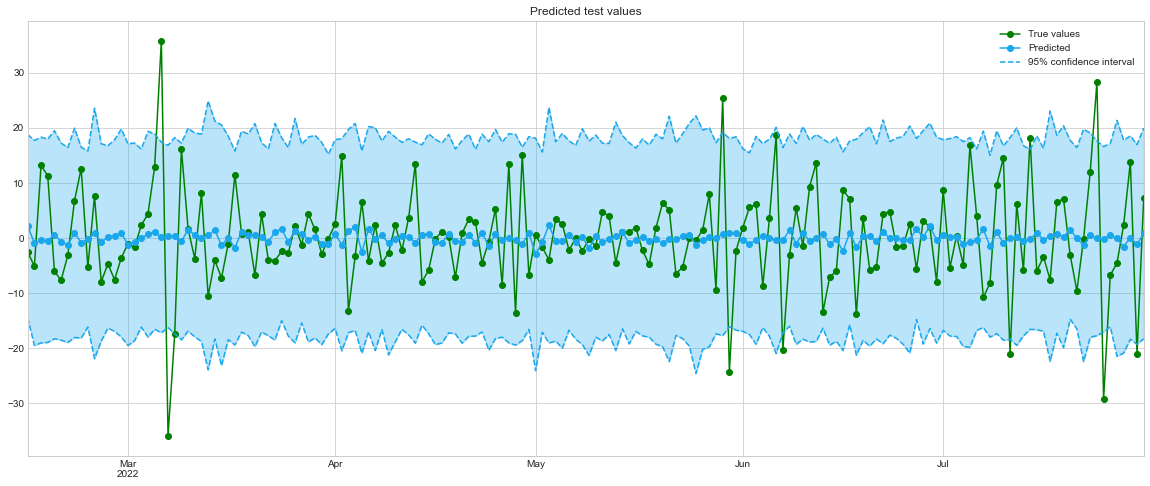

In [27]:
plot_preds(hmc_samples['y_pred'], ar1_std, y_test, 'Ar1')

As it was indicated from the distribution plots of  $\boldsymbol{\beta}$, $\boldsymbol{\sigma}$ and $\boldsymbol{\tau}$, the model is not able learn from the data. Instead it almost just predicts the global mean. It is seen from the confidence interval is wide and contains most of the observations. However, the trends in the data is not detected by the model. 

To be able to compare the model with other model it is evaluated using the evaluate function defined above. 

In [28]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results = pd.DataFrame(results_dict.values(), results_dict.keys(), columns=['AR(1)'])
results

,AR(1)
mse,90.405778
r2,-0.030846
mae,6.944925


## AR(2) Model

The second temporal mode that is tested out is the AR(2) model. This additional complexity could improve the model as indicated in the PACF plot seen in the previous section. 

In [29]:
# Scan function to propogate dynamics (incl 2 prev)
def f(carry, noise_t):
    """
    Function used to propogate dynamics
    """
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

def model(T, T_forecast, obs=None):
    """
    AR(2)-model
    """ 
    # Define priors
    beta1 = numpyro.sample('beta_1', numpyro.distributions.Normal(0.,1.))
    beta2 = numpyro.sample('beta_2', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0., 1.), 
                            sample_shape=(T+T_forecast-2,)) # -2 because AR(2)
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(.01))
    z_prev1 = numpyro.sample('z_1', numpyro.distributions.Normal(0,.1))
    z_prev2 = numpyro.sample('z_2', numpyro.distributions.Normal(0,.1))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed y (y_obs) and prediction y (y_pred)
    y_obs  = numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T],sigma),obs=obs[:T])
    y_pred = numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:],sigma),obs=None)
    return z_collection

In [30]:
# Run inference using MCMC

t0 = time.time()
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), obs=y.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|█████████████████████████| 3000/3000 [02:27<00:00, 20.39it/s, 1023 steps of size 3.00e-03. acc. prob=0.96]


Total time: 2.526m


Again, we extract the values from the predictions and inspect the posterior distributions of 

In [31]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar2_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar2_std = CI95(hmc_samples['y_pred'])

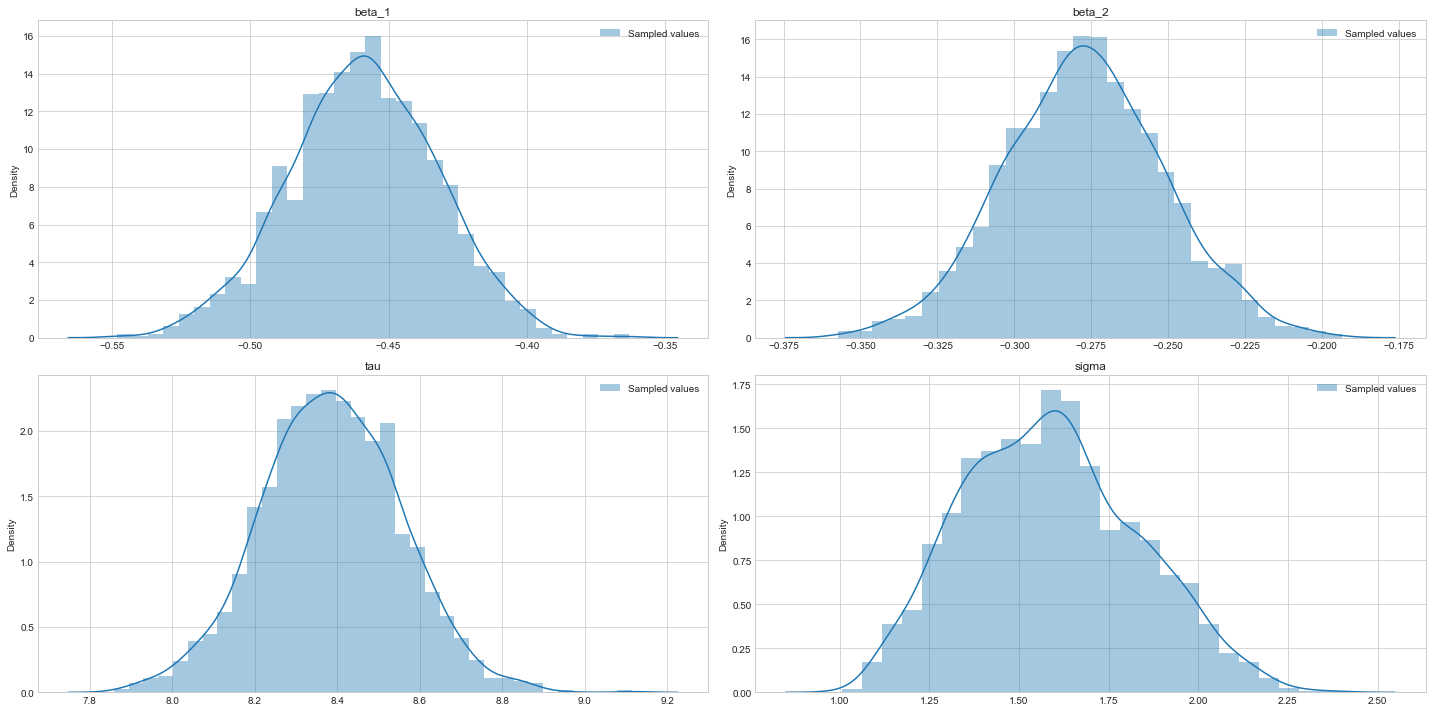

In [32]:
# Visualization of the posterior distributions
nodes = ['beta_1', 'beta_2', 'tau', 'sigma']
fig, ax = plt.subplots(2,2, figsize=(20, 10))
axes = ax.flatten()
for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(2).png', bbox_inches='tight')

Again we see that the $\boldsymbol{\tau}$ is fairly significant compared to the $\boldsymbol{\beta}$ and $\boldsymbol{\sigma}$ parameters indicating the global variance is significant and that the model is not able to accurately predict the target value. However it is notable that the values for $\boldsymbol{\beta}1$ are higher than for  $\boldsymbol{\beta}2$ indicating that the model learns more from time step t-1 than timestep t-2 as we would expect.

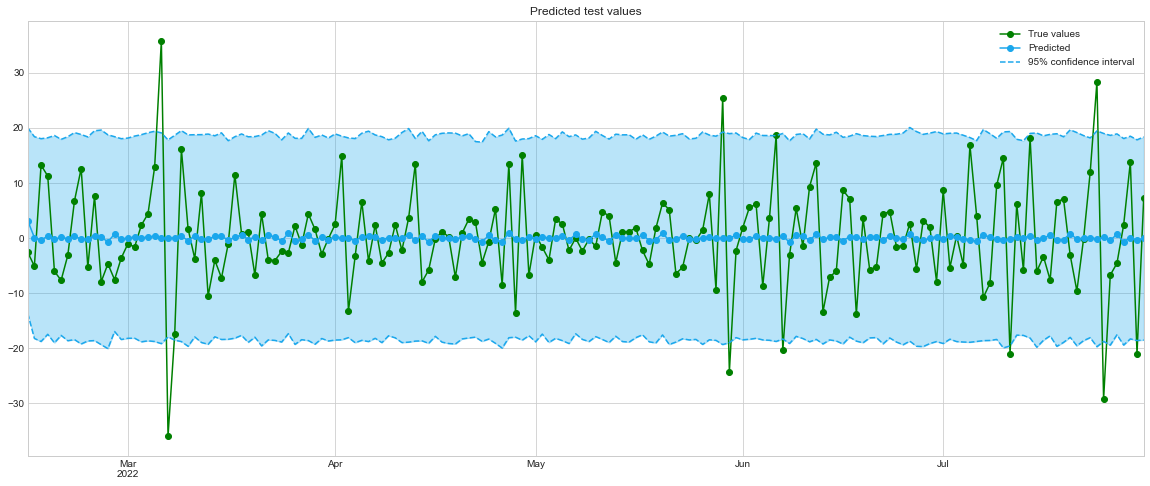

In [33]:
plot_preds(hmc_samples['y_pred'], ar2_std, y_test, 'Ar2')

In [34]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results['AR(2)'] = results_dict.values()
results

,AR(1),AR(2)
mse,90.405778,88.048606
r2,-0.030846,-0.003969
mae,6.944925,6.812383


Looking at the plot and the graph of the predicted values, it is seen that the model is not learning much from the previous values, instead the global variance is significant. A fluctuation in the predicted values are only seen in the beginning of the prediction period. In this period the values also seem to be significantly lower, indicating that the model only take significant changes in the values into account. 

Though, looking at the scores of the evaluation metrics, it is seen that the model has improved compared to the AR(1) model for all the evaluated metrics.

## AR(2) with Weather Features

The last AR-model that will be tried. Is a AR(2) model including the weather features. The weather conditions might be causing some of depature delay hence it is interesting to investigate if it can make the predictions better. 

In [35]:
# Scan for propagation w/ weather data
def f(carry, xs):
    """
    Function used to propogate dynamics
    """
    x_t, noise_t = xs
    tavg = x_t[0]
    prcp = x_t[1]
    wdir = x_t[2]
    wspd = x_t[3]
    pres = x_t[4]
    
    beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1+beta2*z_prev2+tavg*alpha1+prcp*alpha2+wdir*alpha3+wspd*alpha4+pres*alpha5+tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau), z_t

def model(T, T_forecast, x, obs=None):
    """
    AR(2)-model including weather features
    """ 
    # Defining priors
    beta1 = numpyro.sample('beta_1', numpyro.distributions.Normal(0.,1.))
    beta2 = numpyro.sample('beta_2', numpyro.distributions.Normal(0.,1.))
    tau = numpyro.sample('tau', numpyro.distributions.HalfCauchy(.01))
    noises = numpyro.sample('noises', numpyro.distributions.Normal(0., 1.), 
                            sample_shape=(T+T_forecast-2,)) # -2 because AR(2)
    sigma = numpyro.sample('sigma', numpyro.distributions.HalfCauchy(.01))

    # Priors for weather features
    alpha1 = numpyro.sample('alpha_1', numpyro.distributions.Normal(0.,1.))
    alpha2 = numpyro.sample('alpha_2', numpyro.distributions.Normal(0.,1.))
    alpha3 = numpyro.sample('alpha_3', numpyro.distributions.Normal(0.,1.))
    alpha4 = numpyro.sample('alpha_4', numpyro.distributions.Normal(0.,1.))
    alpha5 = numpyro.sample('alpha_5', numpyro.distributions.Normal(0.,1.))
    
    z_prev1 = numpyro.sample('z_1', numpyro.distributions.Normal(0,.1))
    z_prev2 = numpyro.sample('z_2', numpyro.distributions.Normal(0,.1))

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, alpha1, alpha2, alpha3, alpha4, alpha5, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    xs = (x, noises)
    carry, zs_exp = lax.scan(f, carry, xs, T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    # Sample the observed_y (y_obs) and predicted_y (y_pred)
    numpyro.sample('y_obs', numpyro.distributions.Normal(z_collection[:T], sigma), obs=obs[:T])
    numpyro.sample('y_pred', numpyro.distributions.Normal(z_collection[T:], sigma), obs=None)
    
    return z_collection

In [36]:
# Weather features, excluding the first to obs
weather_X = jnp.vstack((X[['tavg','prcp','wdir','wspd','pres']].fillna(0).values[2:,:])) 

In [37]:
# Run inference using MCMC
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=len(y_train), T_forecast=len(y_test), x=weather_X, obs=y_train.values)

t_fin = time.time()

print('Total time: {0:.3f}m'.format((t_fin - t0)/60))

sample: 100%|██████████████████████████| 3000/3000 [01:40<00:00, 29.95it/s, 255 steps of size 1.99e-02. acc. prob=0.92]


Total time: 1.759m


In [38]:
# Extract samples from inference
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}
ar2e_pred = BackDifferencing(df['DepDelayMinutes'], hmc_samples['y_pred'], y_train, len(y_train)+1)
ar2e_std = CI95(hmc_samples['y_pred'])

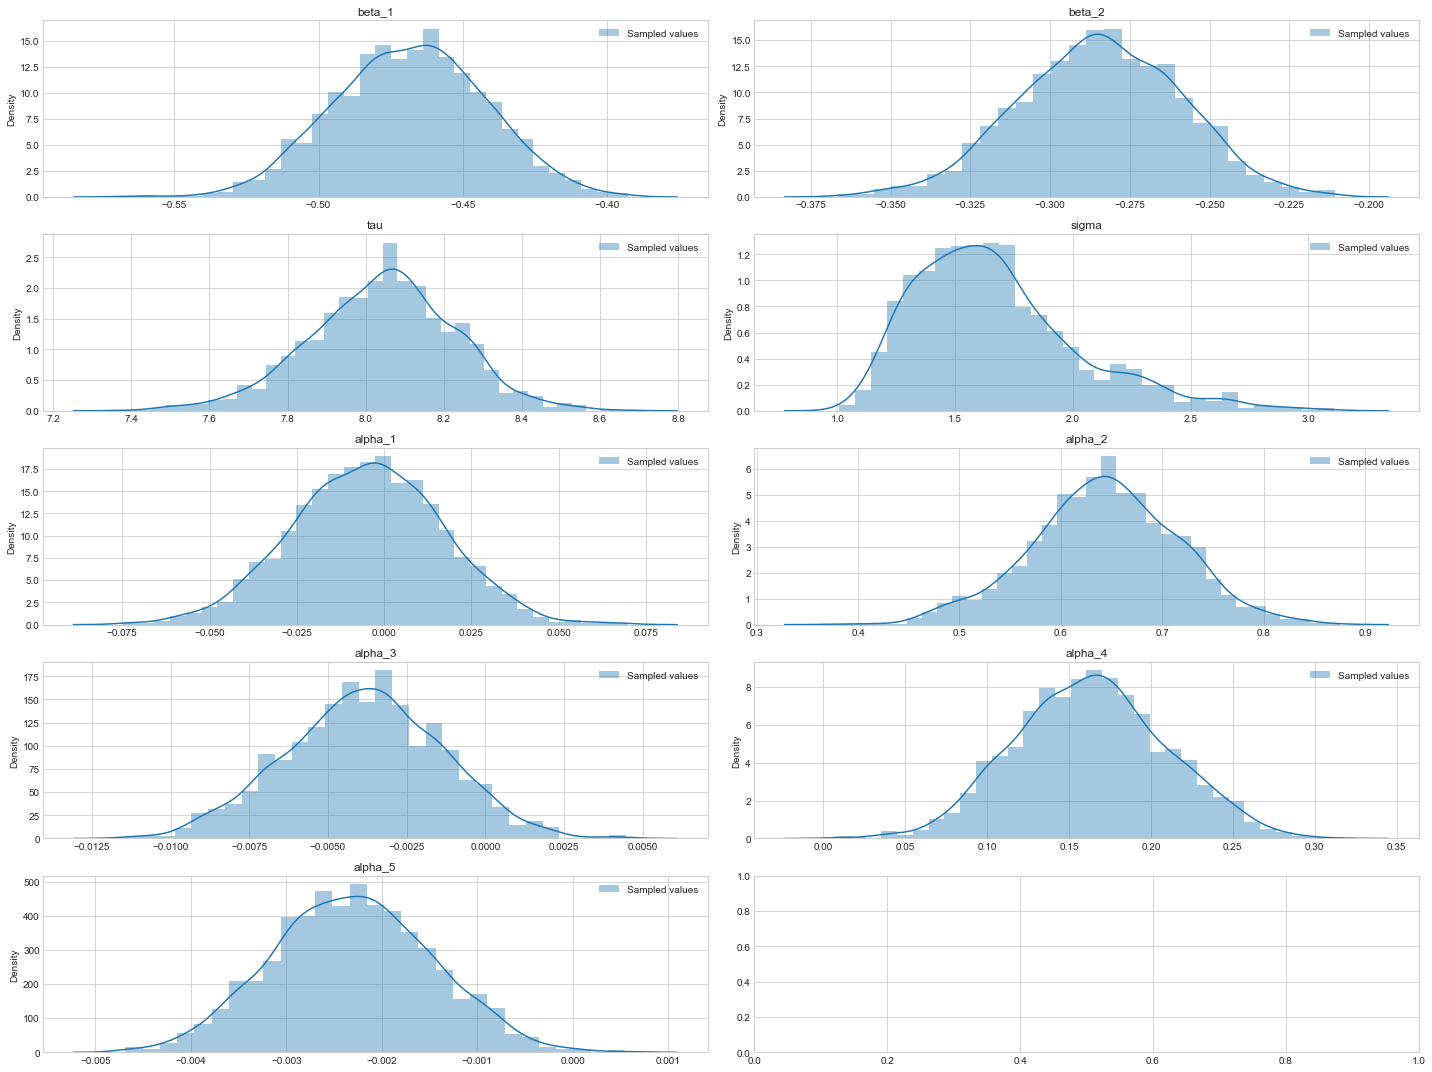

In [39]:
# Visualization of the posterior distributions
nodes = ['beta_1','beta_2', 'tau', 'sigma', 'alpha_1', 'alpha_2', 'alpha_3', 'alpha_4', 'alpha_5']
fig, ax = plt.subplots(5,2, figsize=(20,15))
axes = ax.flatten()

for i, node in enumerate(nodes):
    axes[i].set_title(node)
    sns.distplot(hmc_samples[node], label='Sampled values', ax=axes[i])
    axes[i].legend()
fig.tight_layout()
plt.savefig('figures/parameter_dist_AR(2)_weather.png', bbox_inches='tight')

As for the other models, it is seen that the $\boldsymbol{\tau}$ value is significant compared to the other paramters. 

Of the  $\boldsymbol{\alpha}$ values, $\boldsymbol{\alpha}2$ and $\boldsymbol{\alpha}4$ are most significant. This indicates precipitation and  windspeed are the most significant weather features of the modelled weather features. 

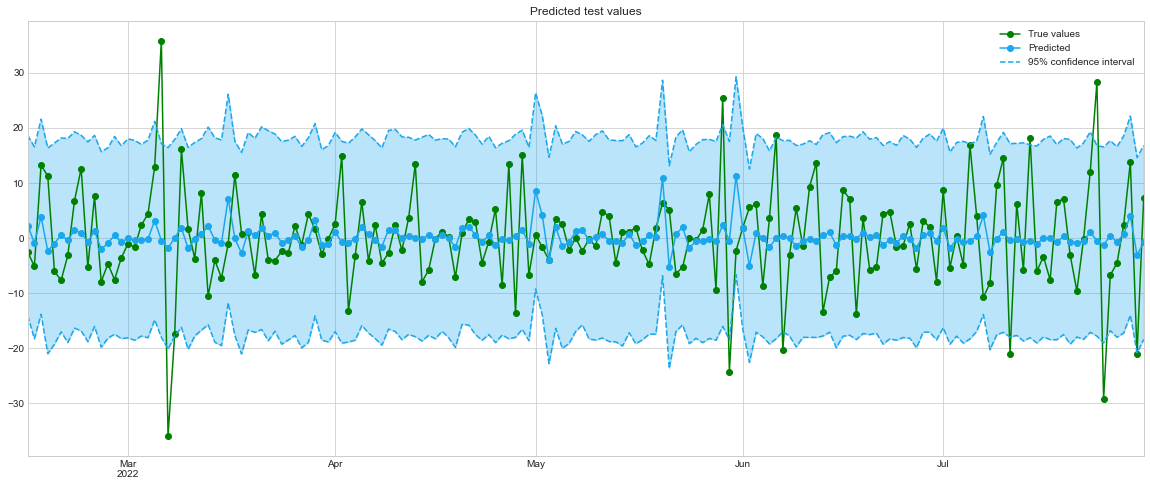

In [40]:
plot_preds(hmc_samples['y_pred'], ar2e_std, y_test, 'Ar2_weather')

In [41]:
results_dict = evaluate(np.array(hmc_samples['y_pred'].mean(axis=0)), y_test)
results['AR(2)-Weather'] = results_dict.values()
results

,AR(1),AR(2),AR(2)-Weather
mse,90.405778,88.048606,86.213370
r2,-0.030846,-0.003969,0.016957
mae,6.944925,6.812383,6.755908


Looking at the plot for the predicted values and evaluation metrics scores, it is seen that the model does not perform any better than the AR(2)-model without the weather features.